<a href="https://colab.research.google.com/github/lamontdobbins3-stack/DataScience/blob/main/Spark%26MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Spark and MapReduce to Understand Airline Reviews (using clustering)
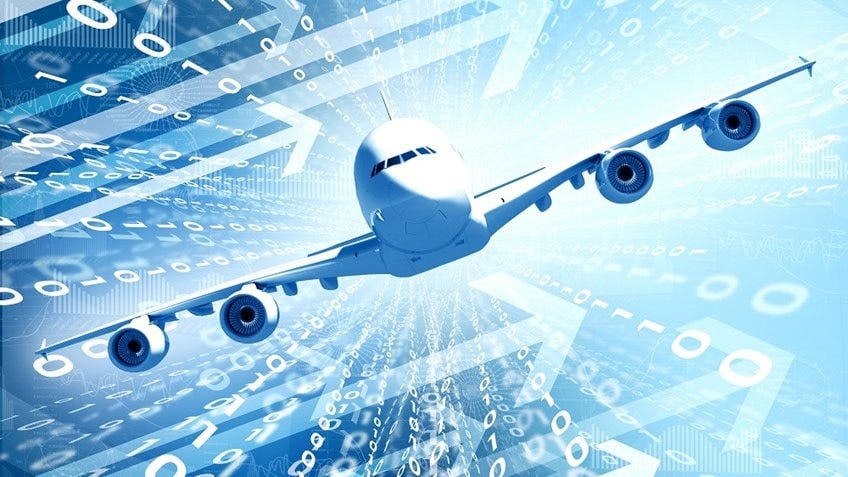

**Overview of the dataset:**

3,700 Survey Results Collected

[
OverallRating: The overall rating given by the customer.

ReviewHeader: The header or title of the customer's review.

Name: The name of the customer providing the feedback.

Datetime: The date and time when the feedback was posted.

VerifiedReview: Indicates whether the review is verified or not.

ReviewBody: The detailed body of the customer's review.

TypeOfTraveller: The type of traveler (e.g., Business, Leisure).

SeatType: Class of the traveler (e.g. Business, Economy).

Route: The flight route taken by the customer.

DateFlown: The date when the flight was taken.

SeatComfort: Rating for seat comfort.

CabinStaffService: Rating for cabin staff service.

GroundService: Rating for ground service.

ValueForMoney: Rating for the value for money.

Recommended: Whether the customer recommends British Airways.

Aircraft: The aircraft used for the flight.

Food&Beverages: Rating for food and beverages.

InflightEntertainment: Rating for inflight entertainment.

Wifi&Connectivity: Rating for onboard wifi and connectivity.
]

In [ ]:
#import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import time
import matplotlib.pyplot as plt
import random
import os
import subprocess

# Install Java, PySpark, and findspark

import os
import subprocess
spark = (
    SparkSession.builder
    .appName("MIS769_HW2")
    .master("local[2]")  # Use 2 CPU cores
    .config("spark.driver.memory", "2g")
    .config("spark.ui.showConsoleProgress", "false")  # Cleaner output
    .getOrCreate()
)

print("✅ Spark Session Created!")
print(f"   App Name: {spark.sparkContext.appName}")
print(f"   Master: {spark.sparkContext.master}")
print(f"   Default Parallelism: {spark.sparkContext.defaultParallelism}")

# Install Java 11
print("📦 Installing Java 11...")
os.system("apt-get update -qq && apt-get install -y -qq openjdk-11-jdk-headless > /dev/null 2>&1")

# Set JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = f"{os.environ['JAVA_HOME']}/bin:" + os.environ["PATH"]

# Verify Java
java_check = subprocess.run(["java", "-version"], capture_output=True, text=True)
print(f"✅ Java installed: {java_check.stderr.split(chr(10))[0]}")

# Install PySpark and findspark (specific versions for compatibility)
print("📦 Installing PySpark...")
os.system("pip install -q pyspark==3.5.0 findspark")

# Initialize findspark
import findspark
findspark.init()

print("✅ Setup complete! You can now run the next cell.")

✅ Spark Session Created!
   App Name: MIS769_HW2
   Master: local[2]
   Default Parallelism: 2
📦 Installing Java 11...
✅ Java installed: openjdk version "11.0.30" 2026-01-20
📦 Installing PySpark...
✅ Setup complete! You can now run the next cell.


In [ ]:
#import dataset from Kaggle via HuggingFace
import kagglehub
from kagglehub import KaggleDatasetAdapter

handle = "chaudharyanshul/airline-reviews"
file_path = "BA_AirlineReviews.csv"

#Load the dataset
hf_ds = kagglehub.dataset_load(
    KaggleDatasetAdapter.HUGGING_FACE,
    handle,
    file_path
)

print(hf_ds)
print(hf_ds.column_names)

Using Colab cache for faster access to the 'airline-reviews' dataset.
Dataset({
    features: ['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime', 'VerifiedReview', 'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route', 'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService', 'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages', 'InflightEntertainment', 'Wifi&Connectivity'],
    num_rows: 3701
})
['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime', 'VerifiedReview', 'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route', 'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService', 'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages', 'InflightEntertainment', 'Wifi&Connectivity']


In [ ]:
#transform to Spark dataframe
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

spark_df = spark.createDataFrame(hf_ds.to_pandas())
spark_df.show(5, truncate=False)

+----------+-------------+----------------------------------------+----------------+------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#Prepare features for clustering
from pyspark.sql.functions import col, when, year, length
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# Create numeric features for clustering
features_df = spark_df.select(
    col("OverallRating"),
    col("TypeOfTraveller"),
    col("SeatType"),
    col("Aircraft"),
    length(col("ReviewBody")).alias("review_length")
).dropna()

#Create aircraft types for easier clustering
features_df = features_df.withColumn(
    "Aircraft_type",
    when(col("Aircraft").rlike("Boeing 777 | Boeing 747-200 | Boeing 777-200 | A380 | Boeing 777"), "WideBody").otherwise("NarrowBody")
)

# Add binary feature for type
features_df = features_df.withColumn(
    "is_business_traveller",
    when(col("TypeOfTraveller") == "Business", 1).otherwise(0)
)

features_df = features_df.withColumn(
    "is_economy_traveller",
    when(col("SeatType") == "Economy Class", 1).otherwise(0)
)

features_df = features_df.withColumn(
    "is_widebody",
    when(col("Aircraft_type") == "WideBody", 1).otherwise(0)
)

features_df = features_df.withColumn(
    "is_narrowbody",
    when(col("Aircraft_type") == "NarrowBody", 1).otherwise(0)
)

df_model = features_df.select(
    "OverallRating",
    "is_widebody",
    "is_narrowbody",
    "is_business_traveller",
    "is_economy_traveller"
)

print(f"✅ Prepared {features_df.count():,} records for clustering")
features_df.show(5)

✅ Prepared 1,921 records for clustering
+-------------+---------------+---------------+--------------+-------------+-------------+---------------------+--------------------+-----------+-------------+
|OverallRating|TypeOfTraveller|       SeatType|      Aircraft|review_length|Aircraft_type|is_business_traveller|is_economy_traveller|is_widebody|is_narrowbody|
+-------------+---------------+---------------+--------------+-------------+-------------+---------------------+--------------------+-----------+-------------+
|          3.0|       Business|  Economy Class|          A320|         1155|   NarrowBody|                    1|                   1|          0|            1|
|          8.0| Couple Leisure| Business Class|          A320|          287|   NarrowBody|                    0|                   0|          0|            1|
|          1.0|   Solo Leisure|  Economy Class|          A320|         1104|   NarrowBody|                    0|                   1|          0|            1|


In [ ]:
# Assemble features into a vector
feature_cols = ["OverallRating", "review_length", "is_economy_traveller","is_widebody"]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw"
)

# Scale features
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Apply transformations
df_assembled = assembler.transform(features_df)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("✅ Features assembled and scaled")

✅ Features assembled and scaled


In [ ]:
# Train K-Means model with 3 clusters
kmeans = KMeans(
    k=3,
    seed=103,
    featuresCol="features",
    predictionCol="cluster"
)

model = kmeans.fit(df_scaled)

# Get predictions
predictions = model.transform(df_scaled)

print("✅ K-Means clustering complete!")
print(f"   Number of clusters: {model.getK()}")

✅ K-Means clustering complete!
   Number of clusters: 3


In [ ]:
# Analyze clusters
from pyspark.sql.functions import avg, count

cluster_stats = predictions.groupBy("cluster").agg(
    count("*").alias("count"),
    avg("OverallRating").alias("ovr_rat"),
    avg("review_length").alias("avg_rev_length"),
    avg("is_economy_traveller").alias("economy"),
    avg("is_widebody").alias("widebody")
).orderBy("cluster")

print("\n📊 CLUSTER ANALYSIS")
print("=" * 60)
cluster_stats.show()


📊 CLUSTER ANALYSIS
+-------+-----+------------------+------------------+------------------+--------------------+
|cluster|count|           ovr_rat|    avg_rev_length|           economy|            widebody|
+-------+-----+------------------+------------------+------------------+--------------------+
|      0|  855|  5.75672514619883| 744.8725146198831|               0.0|0.017543859649122806|
|      1|  797| 5.141781681304893| 731.3199498117942|               1.0|0.018820577164366373|
|      2|  269|3.5985130111524164|2051.7732342007434|0.2899628252788104|0.026022304832713755|
+-------+-----+------------------+------------------+------------------+--------------------+



In [ ]:
# Sample titles from each cluster
print("\n📺 SAMPLE REVIEWS FROM EACH CLUSTER")
print("=" * 60)

for cluster_id in range(3):
    print(f"\n--- Cluster {cluster_id} ---")
    samples = predictions.filter(col("cluster") == cluster_id).select("OverallRating", "review_length", "is_economy_traveller").limit(5)
    samples.show(truncate=False)


📺 SAMPLE REVIEWS FROM EACH CLUSTER

--- Cluster 0 ---
+-------------+-------------+--------------------+
|OverallRating|review_length|is_economy_traveller|
+-------------+-------------+--------------------+
|8.0          |287          |0                   |
|8.0          |881          |0                   |
|8.0          |253          |0                   |
|5.0          |1248         |0                   |
|10.0         |841          |0                   |
+-------------+-------------+--------------------+


--- Cluster 1 ---
+-------------+-------------+--------------------+
|OverallRating|review_length|is_economy_traveller|
+-------------+-------------+--------------------+
|3.0          |1155         |1                   |
|1.0          |1104         |1                   |
|7.0          |376          |1                   |
|2.0          |775          |1                   |
|6.0          |1644         |1                   |
+-------------+-------------+--------------------+


--- C

**Question 3:** Based on your cluster analysis, what characterizes each cluster?

**Cluster 0: Passives** (Business Travellers) - This cluster contains primarily business class flyers and averaged a 5.76 overall rating. This group of travellers left medium review length responses that posed some issues they had with the airline. Aircraft type did not seperate these views, but a majority of the fleet contains wide body aircraft which may skew results.

**Cluster 1: Passives** (Personal Travellers) - In this cluster, passengers were in the economy class and had medium review lengths. Not too long, but also of value. This is essnetial because as passives, we see they are telling us why they are on the fense of either a positive or negative experiance on British Airways. Ultimately, these flyers averaging 5.14 overall rating are having forgettable experiances.

**Cluster 2: Detractors** - In this cluster we have the lowest ratings by far. The average rating is a 3.6 showing more negative experiances. The average feedback in this segment was 2052 characters demonstrating that in many cases the longer the review the more negative the experiance. This group also was made up of mixed traveller types. The most important thing to take from this cluster was that strongly dissatisfied passangers write long detailed complaints, therefore we should perform sentiment analysis and text mine their qualatative data to derive further insights into how British Airways could improve on pain points.


**Question 4:** During the mapping phase, each worker is mapped to a chunk of rows within the current clusters. They are mapped to the nearest centroids for each cluster. In the reduce phase, spark combines the partial results and reduces by the cluster ids. Then the centroids are updated. This process repeates itself iteratively and that is the primary benefit of the mapreduce given that each machine handles each segment accordingly.

# Spark Process Diagram
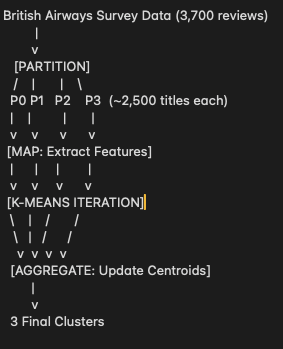

In [ ]:
# Stop Spark session
spark.stop()
print("✅ Spark session stopped. Notebook complete!")

✅ Spark session stopped. Notebook complete!
